In [287]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [314]:
# Load the Bitcoin dataset
data = pd.read_csv('BTC.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-01,377.414001,378.931000,356.562988,362.488007,362.488007,60452200
1,2015-12-02,361.845001,362.231995,349.464996,359.187012,359.187012,54160500
2,2015-12-03,359.330994,370.274994,357.411987,361.045990,361.045990,50714900
3,2015-12-04,361.261993,363.515991,355.756989,363.183014,363.183014,35784100
4,2015-12-05,363.721008,389.785004,363.229004,388.949005,388.949005,66282200


In [315]:
# Perform feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [316]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

In [317]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [318]:
# Create the feature and target datasets
def create_dataset(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i])
        y.append(data[i + 1, 0])  # Consider only the 'Close' column for prediction
    return np.array(X), np.array(y)

In [319]:
X_train, y_train = create_dataset(scaled_train_data)
X_test, y_test = create_dataset(scaled_test_data)

In [320]:
# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [321]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [322]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

In [323]:
from pandas.core.common import random_state
# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/500
65/65 [==============================] - 4s 13ms/step - loss: 0.0160 - val_loss: 0.0029
Epoch 2/500
65/65 [==============================] - 0s 5ms/step - loss: 2.3971e-04 - val_loss: 2.8919e-04
Epoch 3/500
65/65 [==============================] - 0s 5ms/step - loss: 1.0009e-04 - val_loss: 2.4806e-04
Epoch 4/500
65/65 [==============================] - 0s 5ms/step - loss: 8.6261e-05 - val_loss: 2.0579e-04
Epoch 5/500
65/65 [==============================] - 0s 4ms/step - loss: 7.4008e-05 - val_loss: 2.0242e-04
Epoch 6/500
65/65 [==============================] - 0s 4ms/step - loss: 6.1687e-05 - val_loss: 1.6024e-04
Epoch 7/500
65/65 [==============================] - 0s 5ms/step - loss: 5.1901e-05 - val_loss: 1.1094e-04
Epoch 8/500
65/65 [==============================] - 0s 5ms/step - loss: 4.4033e-05 - val_loss: 9.8068e-05
Epoch 9/500
65/65 [==============================] - 0s 4ms/step - loss: 3.7063e-05 - val_loss: 8.7857e-05
Epoch 10/500
65/65 [========================

In [324]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

17/17 [==============================] - 0s 2ms/step


In [325]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate MAPE
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
print("Test MAPE:", test_mape)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-Squared:", test_r2)

Test MAPE: 0.0014121454896134787
Test RMSE: 0.0019112806775556487
Test MAE: 0.0007899038035179892
Test R-Squared: 0.9999288848695027


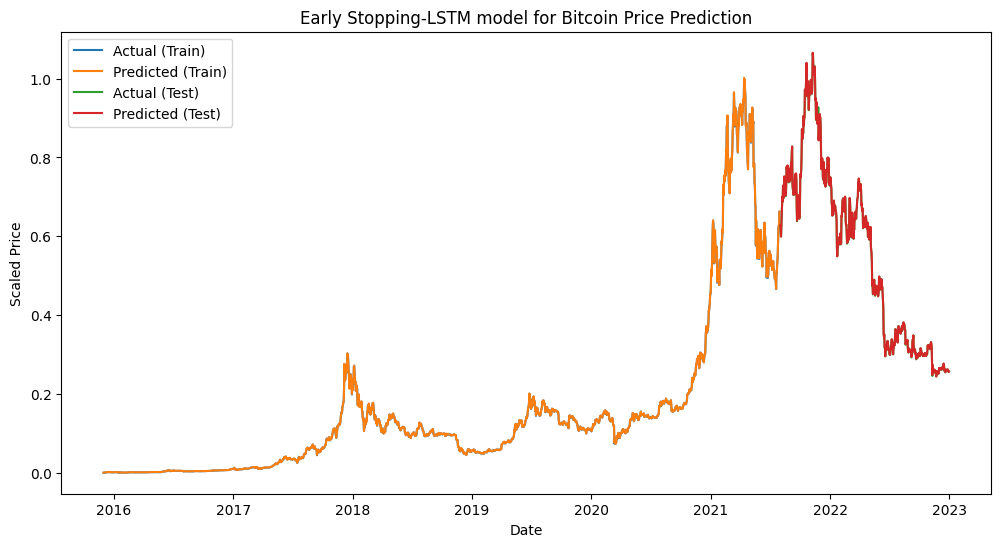

In [326]:
# Plot the actual and predicted prices
train_dates = data.index[:-1][:len(y_train)]
test_dates = data.index[train_size+1:train_size+len(y_test)+1]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, y_train, label='Actual (Train)')
plt.plot(train_dates, train_predictions, label='Predicted (Train)')
plt.plot(test_dates, y_test, label='Actual (Test)')
plt.plot(test_dates, test_predictions, label='Predicted (Test)')
plt.title('Early Stopping-LSTM model for Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

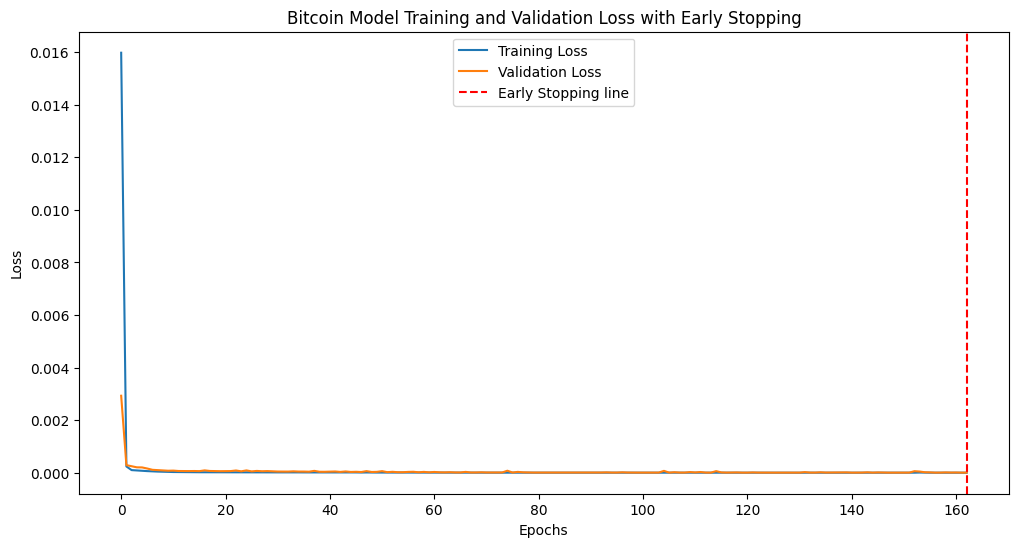

In [328]:
# Plot the training and test errors with early stopping area
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=early_stopping.stopped_epoch, color='red', linestyle='--', label='Early Stopping line')
plt.title('Bitcoin Model Training and Validation Loss with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

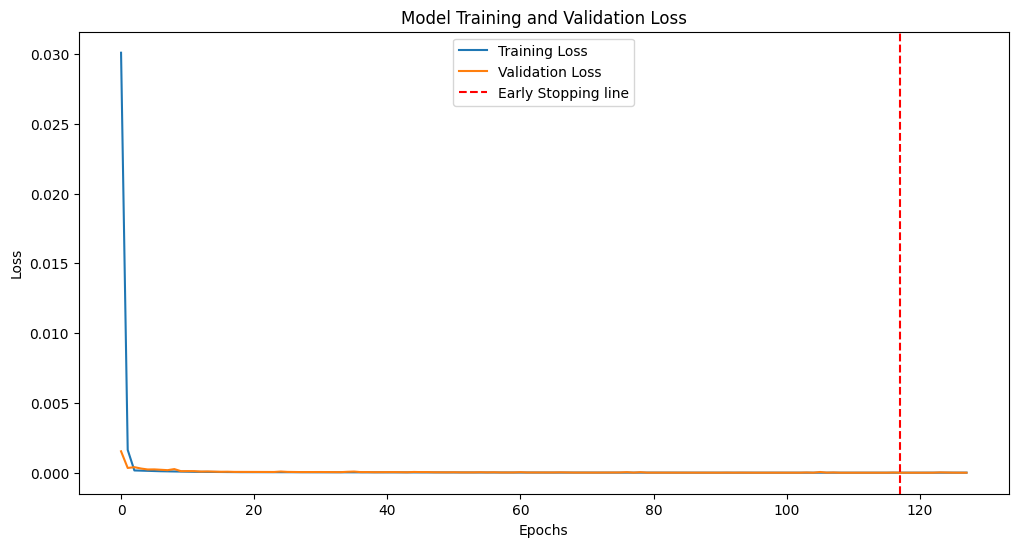

In [ ]:
# Find the epoch where training loss is close to validation loss
val_loss = history.history['val_loss']
train_loss = history.history['loss']
min_loss_diff = min(val_loss)  # Minimum difference between training and validation loss
min_loss_diff_epoch = val_loss.index(min_loss_diff)

# Plot the training and test errors with early stopping area
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=min_loss_diff_epoch, color='red', linestyle='--', label='Early Stopping line')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()